<a href="https://colab.research.google.com/github/Sagar401/Natural_Language_Processing/blob/master/Second_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team: Sagar Daswani and Pimchanok Khaoputhai**
# **FAI - Foundations of AI**

# Final Project
## First report

#**Real or Not? Binary Classification of Disaster Tweets**
Kaggle Competition

In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import string
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [0]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
#Looking at first few rows of dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print("Training Dataset Size:",train_df.shape)
print("Test Dataset Size:",test_df.shape)

Training Dataset Size: (7613, 5)
Test Dataset Size: (3263, 4)


In [5]:
#missing values in training dataset
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
#exlporing location column
train_df['location'].value_counts()

USA                           104
New York                       71
United States                  50
London                         45
Canada                         29
                             ... 
Santa Monica, CA                1
Scottsdale, AZ                  1
buffalo / madrid / granada      1
Atmosphere                      1
Tripsburg, ms.                  1
Name: location, Length: 3341, dtype: int64

##**Data Cleaning**


*   Making all uppercase to lowercase
*   Removing noise from tweets

  *   URLs
  *   HTML tags
  *   emogis
  *   Punctuation
  *   New-Line
  *   Removing Digits
*   Tokenization: Converting normal text string into a list of tokens/words
*   Stopwords removal(optional)


In [0]:
#function to remove noise from text
def clean_text(text):
    text = text.lower() #convert to lowercase to maintain standard flow between text
    text = re.sub('\[.*?\]', '', text) #removing text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #removing url
    text = re.sub('<.*?>+', '', text) #removing html tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #removing puntuations
    text = re.sub('\n', '', text)#removing new line from the text field
    text = re.sub('\w*\d\w*', '', text) #removing digits from the string
    return text

train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
#function to remove emoji's
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df['text']=train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_emoji(x))

In [11]:
#run code to install spell checker package
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [0]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

train_df['text']=train_df['text'].apply(lambda x: correct_spellings(x))
test_df['text']=test_df['text'].apply(lambda x: correct_spellings(x))
        

In [0]:
#adding new column with the count of words in a single row
train_df['word_count'] = train_df['text'].str.split().map(len)

#only using the rows with word count more than 0
train_df = train_df[train_df['word_count'] > 0]

#moving forward with 2 column from dataset , i.e., text and target
train_df = train_df[["text","target"]]
test_df = test_df[["text"]]

In [0]:
train_complete = [ i for i in train_df.text]

training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]
                  
training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]

In [0]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [0]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_complete)

training_sequences=tokenizer_obj.texts_to_sequences(training_sentences)
training_padded=pad_sequences(training_sequences,maxlen=MAX_LEN,truncating='post',padding='post')

test_sequences=tokenizer_obj.texts_to_sequences(test_sentences)
test_padded=pad_sequences(test_sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [29]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 16833


In [31]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16833/16833 [00:00<00:00, 492214.25it/s]


## Baseline model

In [0]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1683400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,725,705
Trainable params: 42,305
Non-trainable params: 1,683,400
_________________________________________________________________


In [0]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [38]:
history=model.fit(training_padded,training_labels,batch_size=4,epochs=15,validation_data=(test_padded,test_labels),verbose=2)




Train on 6000 samples, validate on 1612 samples
Epoch 1/15





 - 55s - loss: 0.6910 - acc: 0.5795 - val_loss: 0.6913 - val_acc: 0.5323
Epoch 2/15
 - 52s - loss: 0.6821 - acc: 0.5805 - val_loss: 0.6828 - val_acc: 0.5323
Epoch 3/15
 - 50s - loss: 0.6636 - acc: 0.5808 - val_loss: 0.6508 - val_acc: 0.5323
Epoch 4/15
 - 50s - loss: 0.6329 - acc: 0.6247 - val_loss: 0.6019 - val_acc: 0.7301
Epoch 5/15
 - 50s - loss: 0.6079 - acc: 0.7028 - val_loss: 0.5713 - val_acc: 0.7730
Epoch 6/15
 - 51s - loss: 0.5897 - acc: 0.7190 - val_loss: 0.5549 - val_acc: 0.7754
Epoch 7/15
 - 52s - loss: 0.5785 - acc: 0.7255 - val_loss: 0.5418 - val_acc: 0.7785
Epoch 8/15
 - 52s - loss: 0.5750 - acc: 0.7357 - val_loss: 0.5281 - val_acc: 0.7767
Epoch 9/15
 - 53s - loss: 0.5712 - acc: 0.7343 - val_loss: 0.5215 - val_acc: 0.7748
Epoch 10/15
 - 53s - loss: 0.5654 - acc: 0.7448 - val_loss: 0.5156 - val_acc: 0.7866
Epoch 11/15
 - 53s - loss: 0.5665 - acc: 0.7317 - val_loss: 0.5121 - val_acc: 0.7847
Epoch 12/15
 - 52s

## **Word Embedding** 
Tensorflow model


In [0]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]
                  
training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]


In [0]:
tokenizer = Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [0]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences,padding='post')


In [0]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_26 (Dense)             (None, 50)                12850     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 982,117
Trainable params: 982,117
Non-trainable params: 0
_______________________________________________

In [0]:
num_epochs = 20
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 - 30s - loss: 0.6809 - accuracy: 0.5805 - val_loss: 0.6903 - val_accuracy: 0.5323
Epoch 2/20
6000/6000 - 24s - loss: 0.5449 - accuracy: 0.6922 - val_loss: 0.5028 - val_accuracy: 0.7407
Epoch 3/20
6000/6000 - 24s - loss: 0.3697 - accuracy: 0.8460 - val_loss: 0.5089 - val_accuracy: 0.7568
Epoch 4/20
6000/6000 - 24s - loss: 0.2956 - accuracy: 0.8842 - val_loss: 0.5019 - val_accuracy: 0.7661
Epoch 5/20
6000/6000 - 24s - loss: 0.2360 - accuracy: 0.9137 - val_loss: 0.5775 - val_accuracy: 0.7215
Epoch 6/20
6000/6000 - 24s - loss: 0.1876 - accuracy: 0.9288 - val_loss: 0.6298 - val_accuracy: 0.7426
Epoch 7/20
6000/6000 - 24s - loss: 0.1529 - accuracy: 0.9468 - val_loss: 0.7191 - val_accuracy: 0.7301
Epoch 8/20
6000/6000 - 24s - loss: 0.1298 - accuracy: 0.9550 - val_loss: 0.7412 - val_accuracy: 0.7196
Epoch 9/20
6000/6000 - 24s - loss: 0.1189 - accuracy: 0.9575 - val_loss: 0.7660 - val_accuracy: 0.7233
Epoch 10/20
6000/6000 - 2

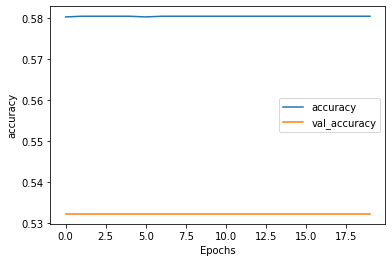

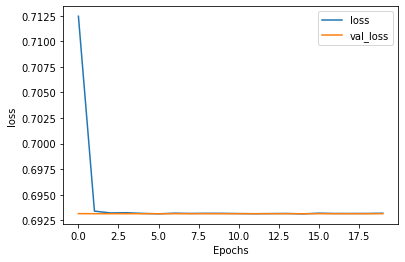

In [0]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(train_df.target[2])

our deeds are the reason of this earthquake may allah forgive us all ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
1


In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [0]:
sentence = ["granny starting to fear spiders in the garden might be real", "coronavirus is spreading in my neighborhood","Coronavirus is love"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, padding='post')
print(model.predict(padded))

[[0.0068009 ]
 [0.67498094]
 [0.02055607]]


     |████████████████████████████████| 1.9MB 2.9MB/s 


In [0]:


correct_spellings(text)

'i love u'

In [0]:
train_df[:14]

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1
5,rockyfire update california hwy closed in bo...,1
6,flood disaster heavy rain causes flash floodin...,1
7,im on top of the hill and i can see a fire in ...,1
8,theres an emergency evacuation happening now i...,1
9,im afraid that the tornado is coming to our area,1
